In [1]:
#Импорт библиотек
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os

import pandas as pd
import time
from IPython import display
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Reshape, Flatten

Загрузка датасета

In [2]:
#Загрузка датасета с лицами
!pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
!tar -xzf /tmp/UTKFace.tar.gz -C /tmp/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
100%|██████████| 107M/107M [00:01<00:00, 73.8MB/s]


In [3]:
os.listdir('/tmp/UTKFace/')

path = os.path.dirname('/tmp/UTKFace/')

base_dir = '/tmp/'

Подготовка датасета

In [4]:
BATCH_SIZE = 128
IMG_SIZE = 32

In [5]:
data_gener = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                            #  rotation_range=30, 
                                                             shear_range=0.2, 
                                                             zoom_range=0.2,
                                                             horizontal_flip=True,
                                                             fill_mode="nearest")

image_generator = data_gener.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory=base_dir, 
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 class_mode=None)

Found 23708 images belonging to 7 classes.


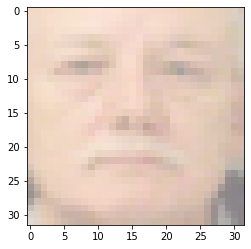

In [6]:
sample = next(image_generator)
plt.imshow((sample[0] + 1.) / 2)

Модель

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
init = RandomNormal(mean=0.0, stddev=0.02)

In [8]:
#@title Модель DCGAN
class DCGAN(tf.keras.Model):
    def __init__(self, image_size, output_path, num_channels=1, z_dim=100,
                 G_h_size=128, D_h_size=128):
        """
        image_size -- размер стороны квадратной картинки
        output_path -- путь для сохранения артефактов обучения.
        num_channels -- количество каналов изображения
        z_dim -- размерность латентного вектора
        G_h_size -- минимальный размер фильтров с сверточных слоях генератора
        D_h_size -- минимальный размер фильтров с сверточных слоях дискриминатора
        """
        super().__init__()
        self.image_size = image_size
        self.num_channels = num_channels
        self.z_dim = z_dim

        self.multiply = int(np.log2(self.image_size / 8)) 
        self.output_path =  Path(output_path)
        (self.output_path / "model").mkdir(exist_ok=True)

        self.G_h_size = G_h_size
        self.D_h_size = D_h_size

        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()

        self.optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
         
        self.gen_loss_hist = []
        self.disc_loss_hist = []
        self._vis_h = 5
        self._vis_w = 5
        self._vis_noise = np.random.normal(0, 1, 
                                           (self._vis_h* self._vis_w, 
                                            self.z_dim)).astype(np.float32)
        self.start_iteration = 0

    def discriminator_loss(self, real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)
    
    def _conv_bn_leaky(self, kernel_size, channels, stride=1):

        model = tf.keras.Sequential()
        model.add(Conv2D(channels,
                         kernel_size=kernel_size, padding="same",
                         use_bias=False, kernel_initializer=init,
                         strides=(stride, stride))) # use_bias=False
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        return model
        

    def _build_generator(self):

        model = tf.keras.Sequential()

        model.add(Reshape((1, 1, self.z_dim), input_shape=(self.z_dim,)))
        model.add(Conv2DTranspose(self.G_h_size * 2**self.multiply,
                                  kernel_size=4, use_bias=False, 
                                  kernel_initializer=init))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        
        for i in range(self.multiply):
            model.add(UpSampling2D())
            model.add(self._conv_bn_leaky(4, self.G_h_size * 2**self.multiply // 2**(i+1)))
        
        assert model.output_shape[1:] == (self.image_size // 2, 
                                          self.image_size // 2, 
                                          self.D_h_size), f"{model.output_shape, self.D_h_size}"
        
        model.add(UpSampling2D())
        model.add(Conv2D(self.num_channels,
                         kernel_size=4, strides=(1, 1),
                         activation="tanh", padding="same", 
                         kernel_initializer=init))
        return model

    def _build_discriminator(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(
            input_shape=((self.image_size, self.image_size, self.num_channels))))
        model.add(self._conv_bn_leaky(kernel_size=4, 
                                      channels=self.D_h_size,
                                      stride=2,
                                      ))
        
        for i in range(self.multiply):
            model.add(self._conv_bn_leaky(kernel_size=4, 
                                          channels=self.D_h_size * (2 ** (i+1)),
                                          stride=2))
        assert model.output_shape[1:] == (4, 4, self.D_h_size * 2**self.multiply), f"{model.output_shape}"
        model.add(Conv2D(1, kernel_size=4, kernel_initializer=init, use_bias=False))
        model.add(Flatten())
        return model
    
    @tf.function
    def train_step(self, images):

        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), self.z_dim])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return gen_loss, disc_loss

    def save_imgs(self, epoch):

        gen_imgs = self.generator(self._vis_noise, training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(self._vis_h, self._vis_w, figsize=(6,6))
        cnt = 0
        for i in range(self._vis_h):
            for j in range(self._vis_w):
                if self.num_channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(self.output_path / f"{epoch}.png")
        plt.show()
    
    def train(self, dataset, num_iters=2000, show_every=25):

        start = time.time()
        iters = self.start_iteration
        for image_batch in dataset:
            print(".", end='')
            gen_loss, disc_loss = self.train_step(image_batch)
            
            self.disc_loss_hist.append(disc_loss.numpy())
            self.gen_loss_hist.append(gen_loss.numpy())    
            
            if iters % show_every == 0:
                display.clear_output(wait=True)
                plt.figure()
                plt.plot(self.disc_loss_hist, label="Discriminator loss")
                plt.plot(self.gen_loss_hist, label="Generator loss")
                plt.legend(loc="best")
                plt.figure()
                self.save_imgs(f"{iters}")
                self.save_weights(str(self.output_path / "model" / "dcgan_model"), save_format='tf')
                
                print(f"\n{iters}/{num_iters}")
                print(f'Time elapsed from start {time.time() - start} sec')
                
            iters += 1
            if iters > num_iters:
                print(f'Finished. Time elapsed from start {time.time() - start} sec')
                return
        

Обучение модели

In [9]:
#Подключим диск для сохранения весов
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Создаем путь для сохранения модели
output = Path("/content/drive/My Drive/gan_utk_32")
output.mkdir(exist_ok=True)
(output / "model").mkdir(exist_ok=True)

In [11]:
#Экземпляр класса модели
gan = DCGAN(image_size=IMG_SIZE, num_channels=3, output_path=output, 
           z_dim=100, D_h_size=128, G_h_size=128)

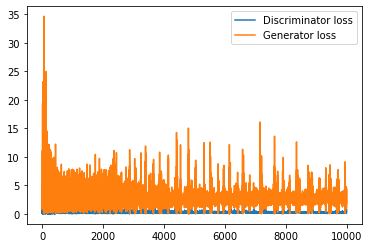

<Figure size 432x288 with 0 Axes>

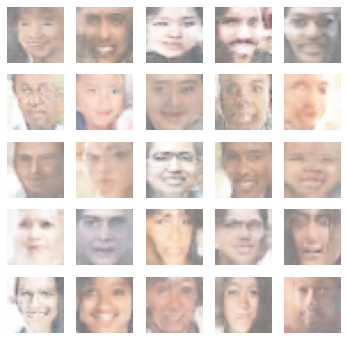


10000/10000
Time elapsed from start 3303.3382432460785 sec
Finished. Time elapsed from start 3303.3382737636566 sec


In [12]:
#Обучение

images = list(output.glob("*.png"))
if images:
    iters = list(map(lambda x: int(x.name.split(".")[0]), images))
    last_iter = sorted(iters)[-1]
    gan.start_iteration = last_iter
    print(f"Resuming model from {last_iter} iteration")
    
gan.train(image_generator, 10000, 50)

Результаты работы модели

In [13]:
def generate_data(latent_vector, generator):

    gen_imgs = generator(latent_vector)
    gen_imgs = 0.5 * gen_imgs + 0.5
    return gen_imgs

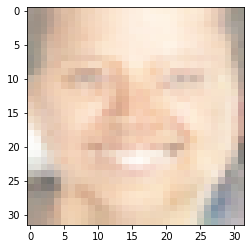

In [17]:
z_vector = tf.random.normal([1, 100]) # случайный вектор

_ = plt.imshow(generate_data(z_vector, gan.generator)[0])